In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding",  # this disables constant folding
#     "--xla_cpu_use_thunk_runtime=false",
# )
from desc import set_device
set_device("gpu")

In [2]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+413.gfb2a5c554.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.09 GB available memory.


## Functions for plotting islands (or not?)

In [5]:
def plot_fieldlines_and_surfaces(field, equ, ntransit=200, nrho=9, size=0.3, outside=False, **kwargs):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    if outside:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, 2))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
        rmax = np.max(r0)
        rmin = np.min(r0)
        r0 = np.linspace(rmin, rmax + (rmax-rmin)*0.05, nrho)
        z0 = np.zeros_like(r0)
    else:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, nrho))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
    fig, ax = plot_surfaces(equ)
    fig, ax = poincare_plot(
        field,
        r0,
        z0,
        NFP=equ.NFP,
        ax=ax,
        color="k",
        size=size,
        ntransit=ntransit,
        bounds_R=(0.5, 1.5),
        bounds_Z=(-0.7, 0.7),
        **kwargs,
    )
    return fig, ax

In [21]:
def optimize_coils_regcoil(surf, equ, num_coils=16, return_k=False):
    # create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
    surface_current_field = FourierCurrentPotentialField.from_surface(
        surf,
        I=0,
        # manually setting G to value needed to provide the equilibrium's toroidal flux,
        # though this is not necessary as it gets set automatically inside the solve_regularized_surface_current function
        G=np.asarray(
            [
                -equ.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0]
                / mu_0
                * 2
                * np.pi
            ]
        ),
        # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
        sym_Phi="sin",
    )

    surface_current_field.change_Phi_resolution(M=12, N=12)

    # create the evaluation grid (where Bn will be minimized on plasma surface)
    # and source grid (discretizes the source K for Biot-Savart and where |K| will be penalized on winding surface)
    Megrid = 20
    Negrid = 20
    Msgrid = 20
    Nsgrid = 20

    eval_grid = LinearGrid(M=Megrid, N=Negrid, NFP=equ.NFP, sym=False)
    # ensure that sym=False for source grid so the field evaluated from the surface current is accurate
    # (i.e. must evaluate source over whole surface, not just the symmetric part)
    # NFP>1 is ok, as we internally will rotate the source through the field periods to sample entire winding surface
    sgrid = LinearGrid(M=Msgrid, N=Nsgrid, NFP=equ.NFP, sym=False)

    lambda_regularization = np.append(np.array([0]), np.logspace(-30, 1, 20))

    # solve_regularized_surface_current method runs the REGCOIL algorithm
    fields, data = solve_regularized_surface_current(
        surface_current_field,  # the surface current field whose geometry and Phi resolution will be used
        eq=equ,  # the Equilibrium object to minimize Bn on the surface of
        source_grid=sgrid,  # source grid
        eval_grid=eval_grid,  # evaluation grid
        current_helicity=(
            1*surface_current_field.NFP,
            -1,
        ),  # pair of integers (M_coil, N_coil), determines topology of contours (almost like  QS helicity),
        #  M_coil is the number of times the coil transits poloidally before closing back on itself
        # and N_coil is the toroidal analog (if M_coil!=0 and N_coil=0, we have modular coils, if both M_coil
        # and N_coil are nonzero, we have helical coils)
        # we pass in an array to perform scan over the regularization parameter (which we call lambda_regularization)
        # to see tradeoff between Bn and current complexity
        lambda_regularization=lambda_regularization,
        # lambda_regularization can also be just a single number in which case no scan is performed
        vacuum=True,  # this is a vacuum equilibrium, so no need to calculate the Bn contribution from the plasma currents
        regularization_type="regcoil",
        chunk_size=40,
    )
    surface_current_field = fields[
        0
    ]  # fields is a list of FourierCurrentPotentialField objects

    if return_k:
        return surface_current_field
    else:
        coilset = surface_current_field.to_CoilSet(num_coils=num_coils, stell_sym=True)
        return coilset


def optimize_field_and_plot_result(eq, nrho=18, ntransit=200, size=0.3, offset=0.25):
    eq.surface = eq.get_surface_at(rho=1.0)
    # create the constant offset surface
    surf = eq.surface.constant_offset_surface(
        offset=offset,  # desired offset
        M=16,  # Poloidal resolution of desired offset surface
        N=16,  # Toroidal resolution of desired offset surface
        grid=LinearGrid(M=32, N=32, NFP=eq.NFP),
    )
    optimized_coilset = optimize_coils_regcoil(surf, eq, num_coils=8, return_k=True)
    return plot_fieldlines_and_surfaces(
        optimized_coilset, eq, nrho=nrho, ntransit=ntransit, size=size, outside=False
    )

# Aim for similar XSection and Surface

In [8]:
eq0 = desc.io.load(
    "./ISLAND_STUFF/LANDREMAN2021/eq-org/eq-org-landreman2021-island-L16M16N4.h5"
)
eq_opt = eq0.copy()
eq_opt.change_resolution(L=8, M=4, N=4)
eq_opt.change_resolution(L=16, M=16, N=4, L_grid=24, M_grid=24, N_grid=8)
eq_opt.xsection = eq_opt.get_surface_at(zeta=0.0)
eq_opt.surface = eq_opt.get_surface_at(rho=1.0)
eq_opt.axis = eq_opt.get_axis()

/CODES/DESC/desc/utils.py:572: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(msg, err)


In [9]:
w_force = 1000
w_section = 100
w_surface = 0.1
obj2 = ObjectiveFunction(
    [
        ForceBalance(eq_opt, weight=w_force),
        FixSectionR(eq_opt, remove_optimizables=False, weight=w_section),
        FixSectionZ(eq_opt, remove_optimizables=False, weight=w_section),
        FixBoundaryR(eq_opt, remove_optimizables=False, weight=w_surface),
        FixBoundaryZ(eq_opt, remove_optimizables=False, weight=w_surface),
    ]
)

In [10]:
cons = (FixPressure(eq_opt), FixPsi(eq_opt), FixCurrent(eq_opt), FixLambdaGauge(eq_opt), FixSheetCurrent(eq_opt))
cons = maybe_add_self_consistency(eq_opt, cons)

In [11]:
eq_opt.solve(objective=obj2, constraints=cons, verbose=3, ftol=1e-2, maxiter=100);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 860 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Timer: Objective build = 2.31 sec
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Building objective: lambda gauge
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 208 ms
Timer: LinearConstraintProjection build = 5.40 sec
Number of parameters: 2061
Number of objectives: 6196
Timer: Initializing the optimization = 8.23 sec

Starting optimization
Using method: lsq-exact
   It

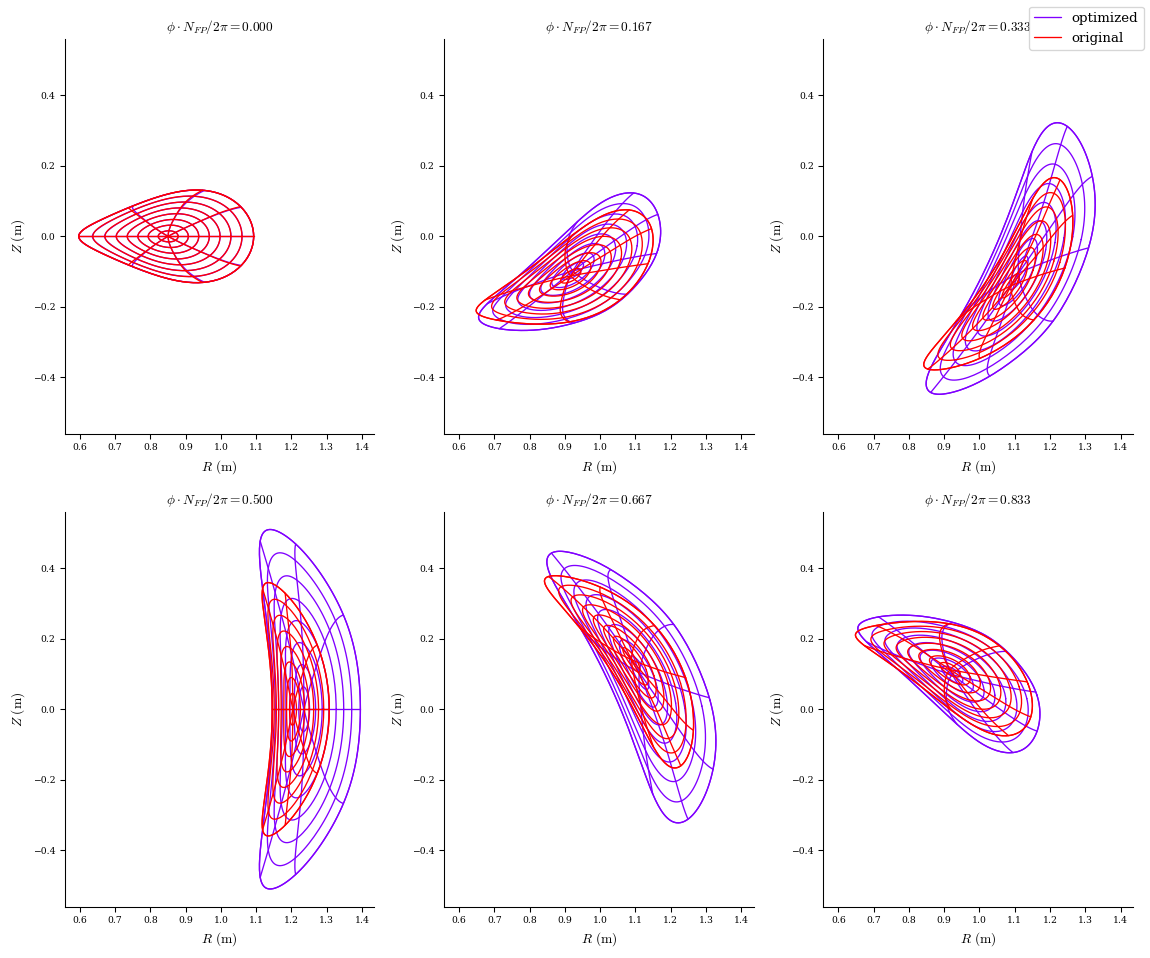

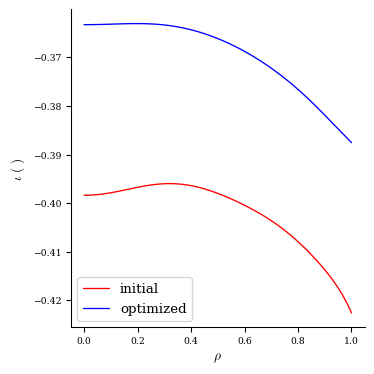

In [12]:
plot_comparison([eq_opt, eq0], labels=["optimized", "original"])
fig, ax = plot_1d(eq0, "iota", label="initial", color="red")
plot_1d(eq_opt, "iota", ax=ax, label="optimized", color="blue");

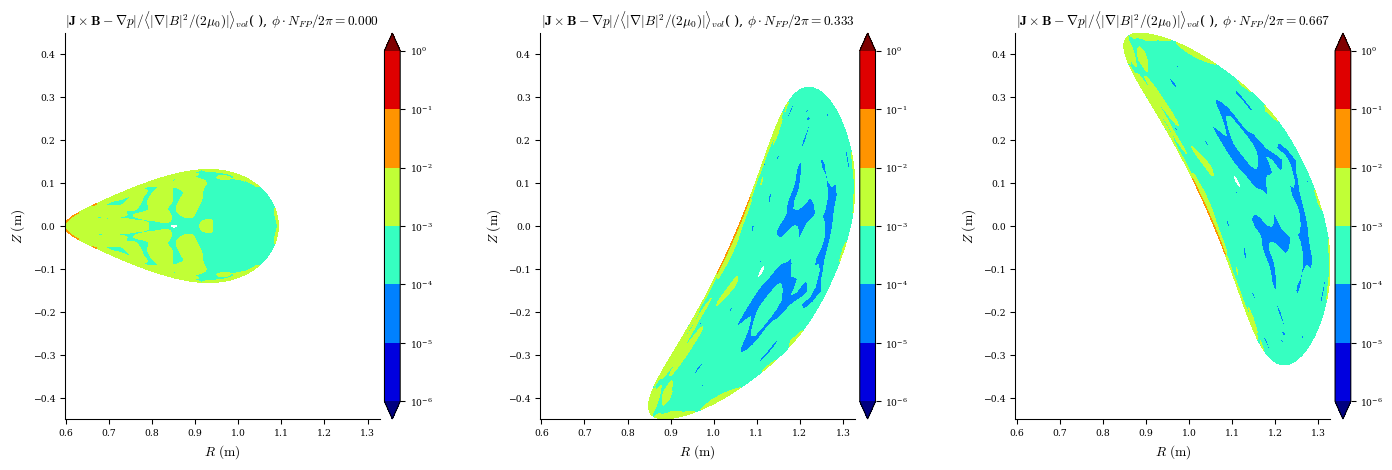

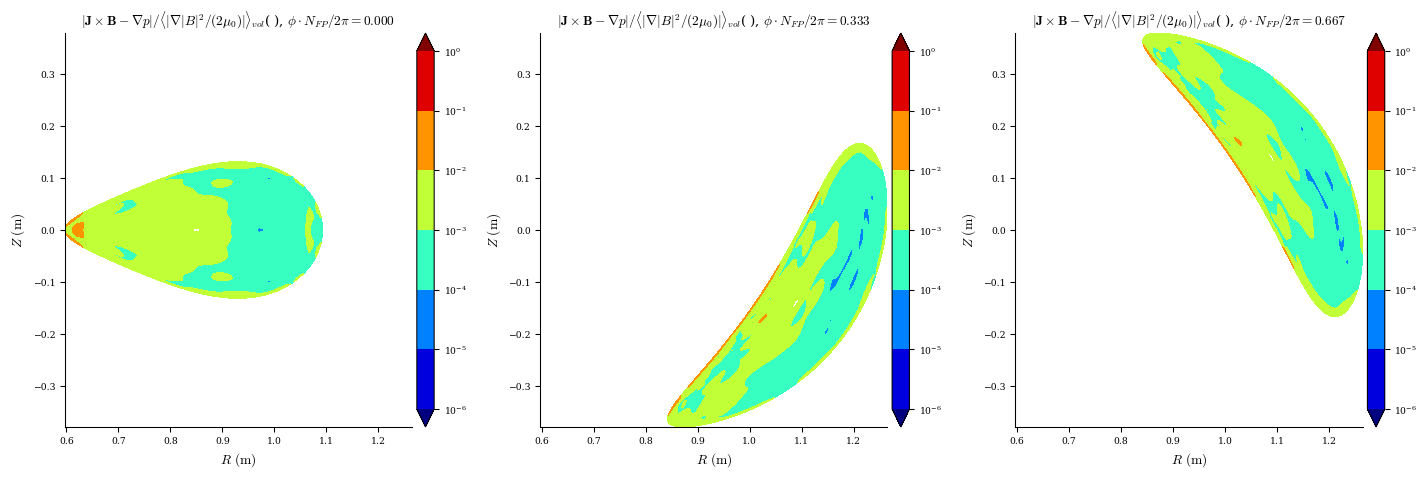

In [13]:
plot_section(eq_opt, "|F|_normalized", phi=3, log=True)
plot_section(eq0, "|F|_normalized", phi=3, log=True);

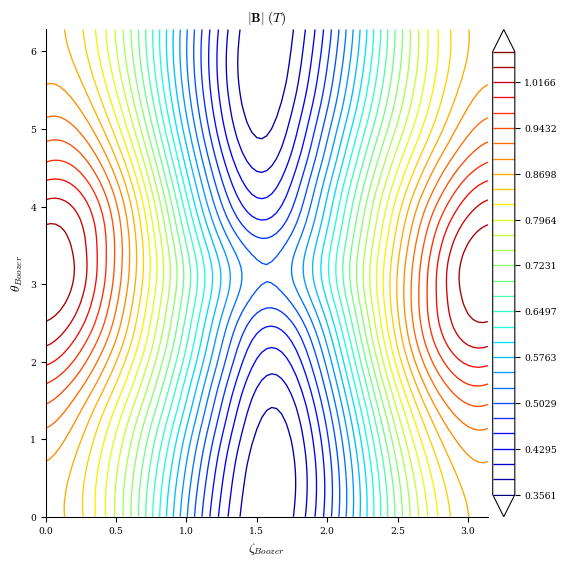

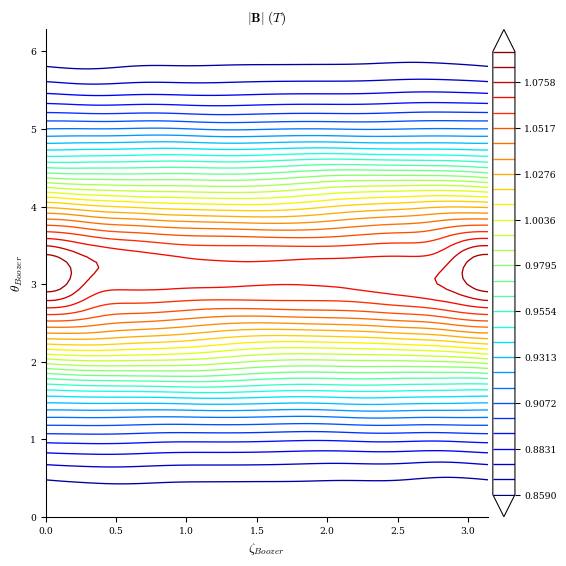

In [14]:
plot_boozer_surface(eq_opt)
plot_boozer_surface(eq0);

##########################################################
Calculating Phi_SV for lambda_regularization = 0.00000e+00
##########################################################
chi^2 B = 2.75472e-09
min Bnormal = 4.71998e-19 (T)
Max Bnormal = 3.06914e-07 (T)
Avg Bnormal = 7.63476e-08 (T)
min Bnormal = 6.85695e-19 (unitless)
Max Bnormal = 4.45869e-07 (unitless)
Avg Bnormal = 1.10914e-07 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-30
##########################################################
chi^2 B = 2.75472e-09
min Bnormal = 4.53336e-19 (T)
Max Bnormal = 3.06914e-07 (T)
Avg Bnormal = 7.63476e-08 (T)
min Bnormal = 6.58584e-19 (unitless)
Max Bnormal = 4.45869e-07 (unitless)
Avg Bnormal = 1.10914e-07 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 4.28133e-29
##########################################################
chi^2 B = 2.75472e-09
m

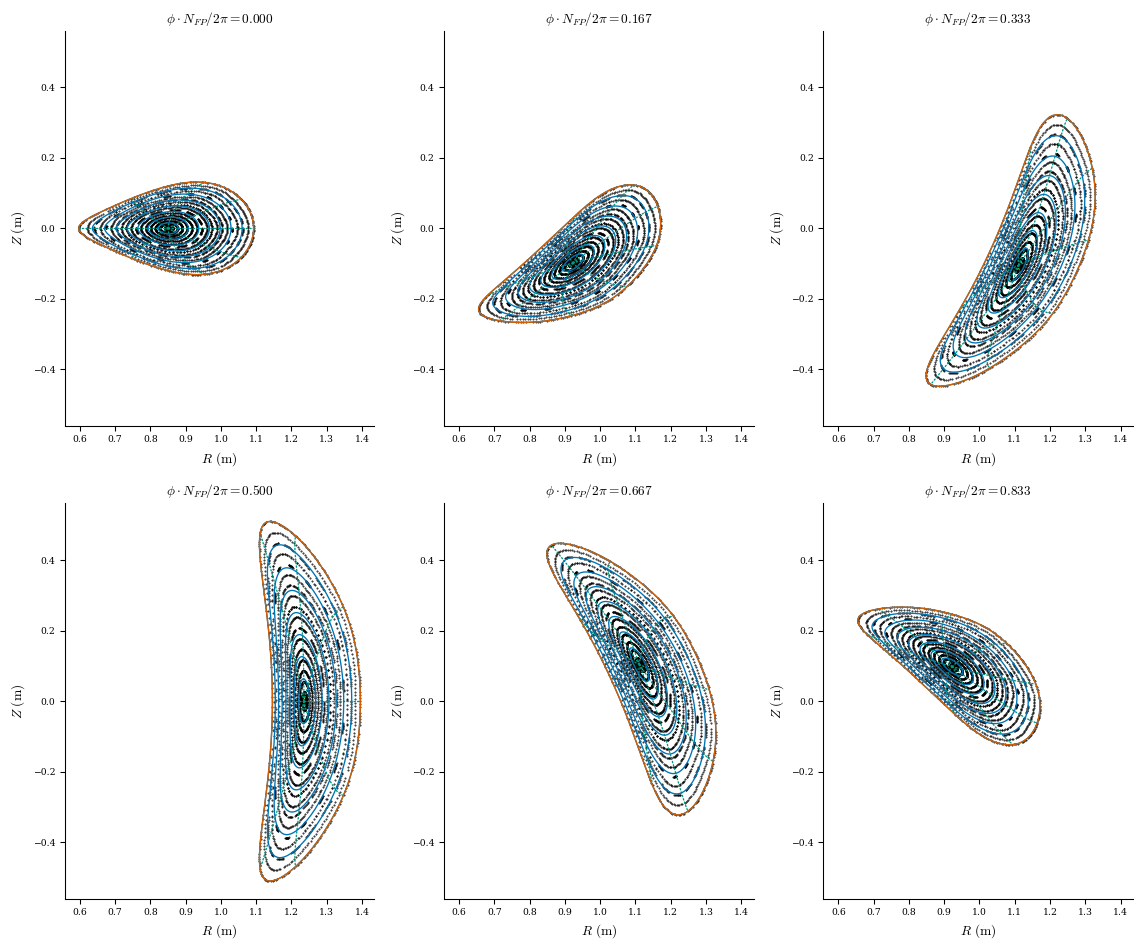

In [15]:
fig, ax = optimize_field_and_plot_result(eq_opt, nrho=18, ntransit=200, size=0.2)
# fig.savefig(
#     f"plot-landreman2021-optimize-poincare-L{eq_opt.L}M{eq_opt.M}N{eq_opt.N}.png", dpi=1000
# )

# Try with XSection and AspectRatio

In [16]:
eq0 = desc.io.load(
    "./ISLAND_STUFF/LANDREMAN2021/eq-org/eq-org-landreman2021-island-L16M16N4.h5"
)
eq_opt2 = eq0.copy()
eq_opt2.change_resolution(L=8, M=4, N=4)
eq_opt2.change_resolution(L=16, M=16, N=4, L_grid=24, M_grid=24, N_grid=8)
eq_opt2.xsection = eq_opt2.get_surface_at(zeta=0.0)
eq_opt2.surface = eq_opt2.get_surface_at(rho=1.0)
eq_opt2.axis = eq_opt2.get_axis()

w_force = 1000
w_section = 100
w_surface = 1
obj2 = ObjectiveFunction(
    [
        ForceBalance(eq_opt2, weight=w_force),
        FixSectionR(eq_opt2, remove_optimizables=True, weight=w_section),
        FixSectionZ(eq_opt2, remove_optimizables=True, weight=w_section),
        AspectRatio(eq_opt2, target=6.0, weight=w_surface),
    ]
)

cons = (
    FixPressure(eq_opt2),
    FixPsi(eq_opt2),
    FixCurrent(eq_opt2),
    FixLambdaGauge(eq_opt2),
    FixSheetCurrent(eq_opt2),
)
cons = maybe_add_self_consistency(eq_opt2, cons)

eq_opt2.solve(objective=obj2, constraints=cons, verbose=3, ftol=1e-2, maxiter=100);
eq_opt2.xsection = eq_opt2.get_surface_at(zeta=0.0)
eq_opt2.surface = eq_opt2.get_surface_at(rho=1.0)
eq_opt2.axis = eq_opt2.get_axis()

/CODES/DESC/desc/utils.py:572: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(msg, err)


Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 81.4 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 47.1 ms
Timer: Objective build = 679 ms
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Building objective: lambda gauge
Building objective: fixed sheet current
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 96.8 ms
Timer: LinearConstraintProjection build = 3.74 sec
Number of parameters: 2061
Number of objectives: 5900
Timer: Initializing the optimization = 4.86 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction  

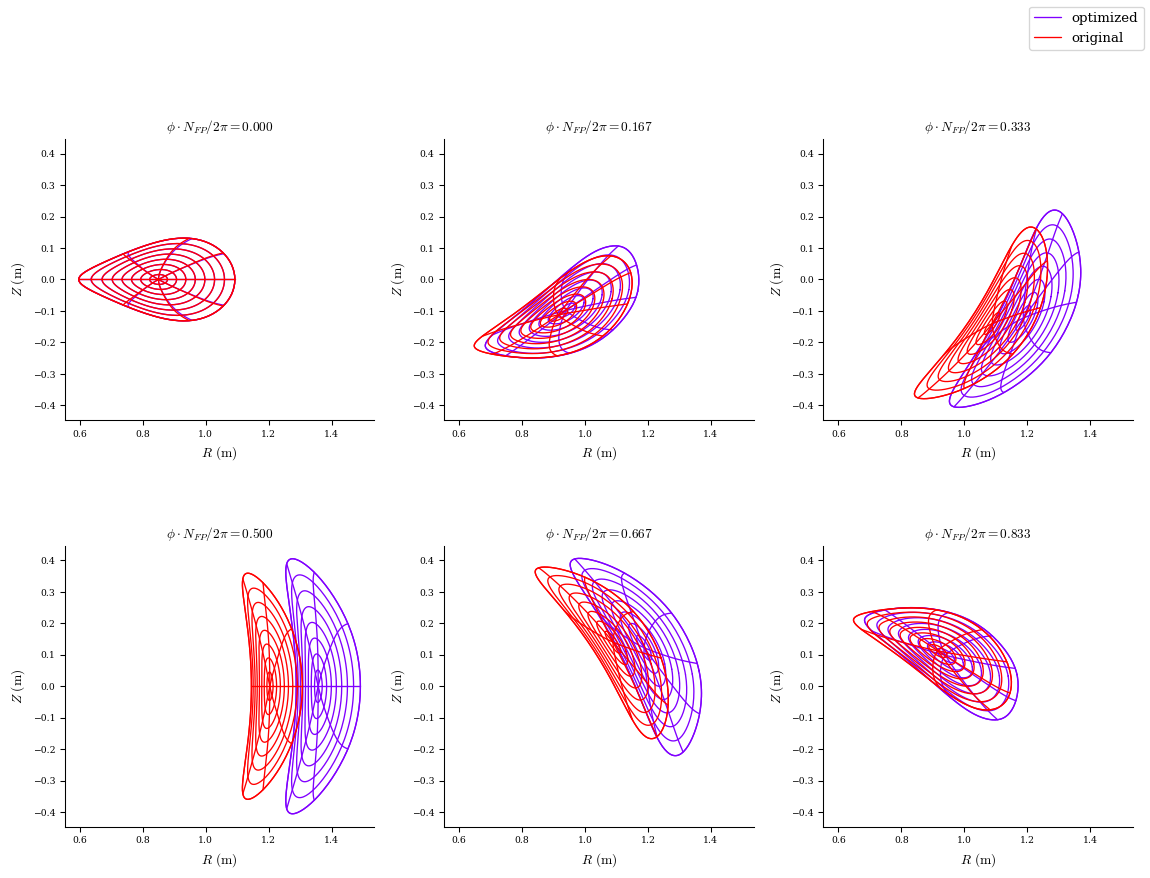

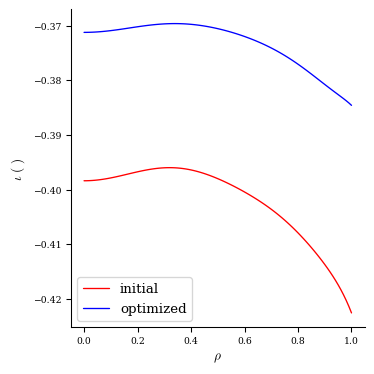

In [17]:
plot_comparison([eq_opt2, eq0], labels=["optimized", "original"])
fig, ax = plot_1d(eq0, "iota", label="initial", color="red")
plot_1d(eq_opt2, "iota", ax=ax, label="optimized", color="blue");

##########################################################
Calculating Phi_SV for lambda_regularization = 0.00000e+00
##########################################################
chi^2 B = 1.91916e-09
min Bnormal = 5.38187e-19 (T)
Max Bnormal = 2.54380e-07 (T)
Avg Bnormal = 6.27927e-08 (T)
min Bnormal = 6.31974e-19 (unitless)
Max Bnormal = 2.98709e-07 (unitless)
Avg Bnormal = 7.37353e-08 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-30
##########################################################
chi^2 B = 1.91916e-09
min Bnormal = 3.58636e-19 (T)
Max Bnormal = 2.54380e-07 (T)
Avg Bnormal = 6.27927e-08 (T)
min Bnormal = 4.21133e-19 (unitless)
Max Bnormal = 2.98709e-07 (unitless)
Avg Bnormal = 7.37353e-08 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 4.28133e-29
##########################################################
chi^2 B = 1.91916e-09
m

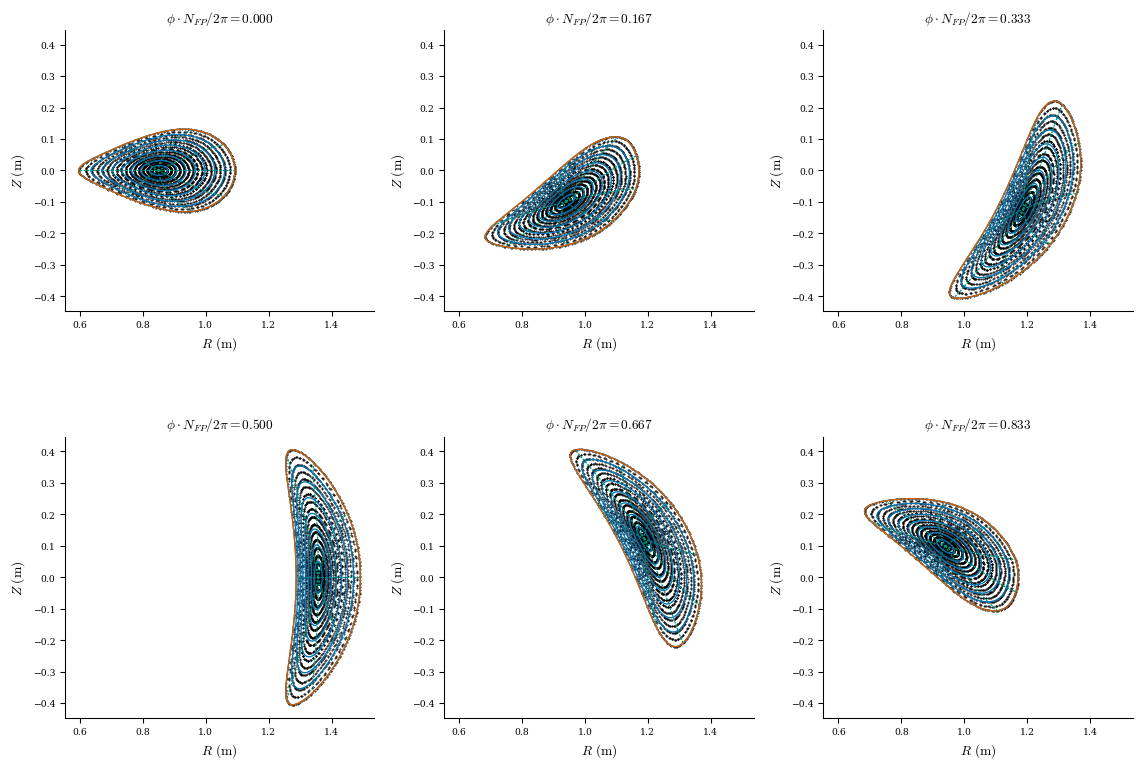

In [18]:
fig, ax = optimize_field_and_plot_result(eq_opt2, nrho=18, ntransit=200, size=0.2)

(<Figure size 576.113x576.113 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

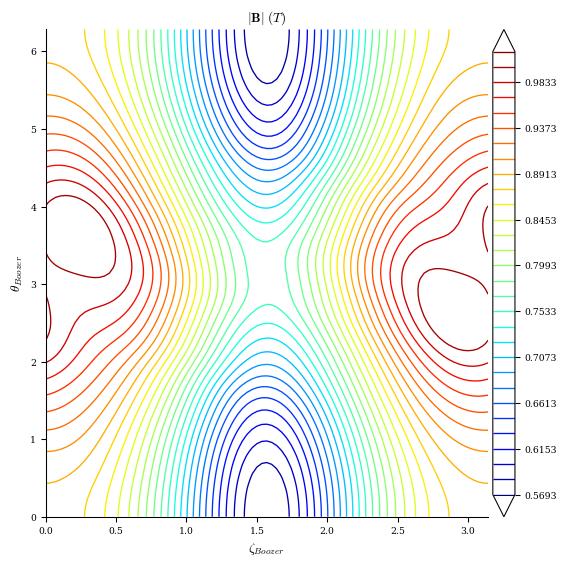

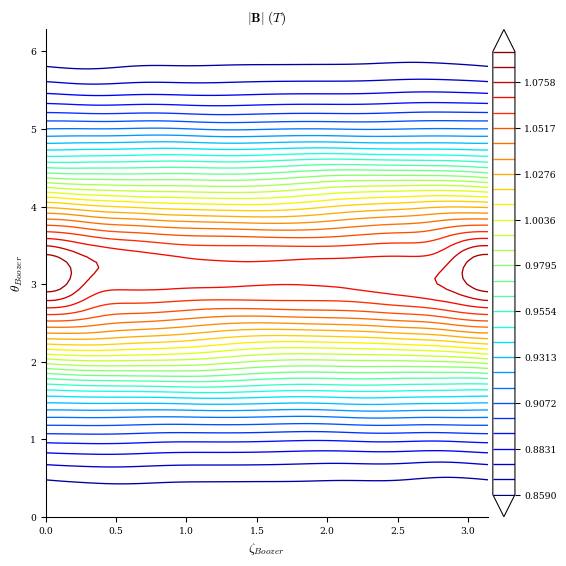

In [19]:
plot_boozer_surface(eq_opt2)
plot_boozer_surface(eq0);

In [20]:
plot_3d(eq_opt2, "|B|")

/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)


In [21]:
plot_3d(eq_opt, "|B|")

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



## Maybe aim for edge iota

In [37]:
eq0 = desc.io.load(
    "./ISLAND_STUFF/LANDREMAN2021/eq-org/eq-org-landreman2021-island-L16M16N4.h5"
)
eq_opt3 = eq0.copy()
eq_opt3.change_resolution(L=8, M=4, N=4)
eq_opt3.change_resolution(L=16, M=16, N=4, L_grid=24, M_grid=24, N_grid=8)
eq_opt3.xsection = eq_opt3.get_surface_at(zeta=0.0)
eq_opt3.surface = eq_opt3.get_surface_at(rho=1.0)
eq_opt3.axis = eq_opt3.get_axis()

iota_grid = LinearGrid(rho=np.array([1.0]), M=eq0.M_grid, N=eq0.N_grid, NFP=eq0.NFP, sym=eq0.sym)

w_force = 10000
w_section = 10
w_surface = 1
w_iota = 10
# obj2 = ObjectiveFunction(
#     [
#         ForceBalance(eq_opt3, weight=w_force),
#         FixSectionR(eq_opt3, remove_optimizables=True, weight=w_section),
#         FixSectionZ(eq_opt3, remove_optimizables=True, weight=w_section),
#         AspectRatio(eq_opt3, target=6.0, weight=w_surface),
#         RotationalTransform(eq_opt3, target=-0.42, grid=iota_grid, weight=w_iota),
#     ]
# )
obj2 = ObjectiveFunction(
    [
        ForceBalance(eq_opt3, weight=w_force),
        FixSectionR(eq_opt3, remove_optimizables=False, weight=w_section),
        FixSectionZ(eq_opt3, remove_optimizables=False, weight=w_section),
        FixBoundaryR(eq_opt3, remove_optimizables=False, weight=w_surface),
        FixBoundaryZ(eq_opt3, remove_optimizables=False, weight=w_surface),
        RotationalTransform(eq_opt3, target=-0.42, grid=iota_grid, weight=w_iota),
    ]
)

cons = (
    FixPressure(eq_opt3),
    FixPsi(eq_opt3),
    FixCurrent(eq_opt3),
    FixLambdaGauge(eq_opt3),
    FixSheetCurrent(eq_opt3),
)
cons = maybe_add_self_consistency(eq_opt3, cons)

eq_opt3.solve(objective=obj2, constraints=cons, verbose=3, ftol=1e-2, maxiter=100)
eq_opt3.xsection = eq_opt3.get_surface_at(zeta=0.0)
eq_opt3.surface = eq_opt3.get_surface_at(rho=1.0)
eq_opt3.axis = eq_opt3.get_axis()

/CODES/DESC/desc/utils.py:572: UserWarning:

Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`



Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 76.0 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 30.6 ms
Timer: Objective build = 195 ms
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Building objective: lambda gauge
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 111 ms
Timer: LinearConstraintProjection build = 636 ms
Number of parameters: 2061
Number of objectives: 61

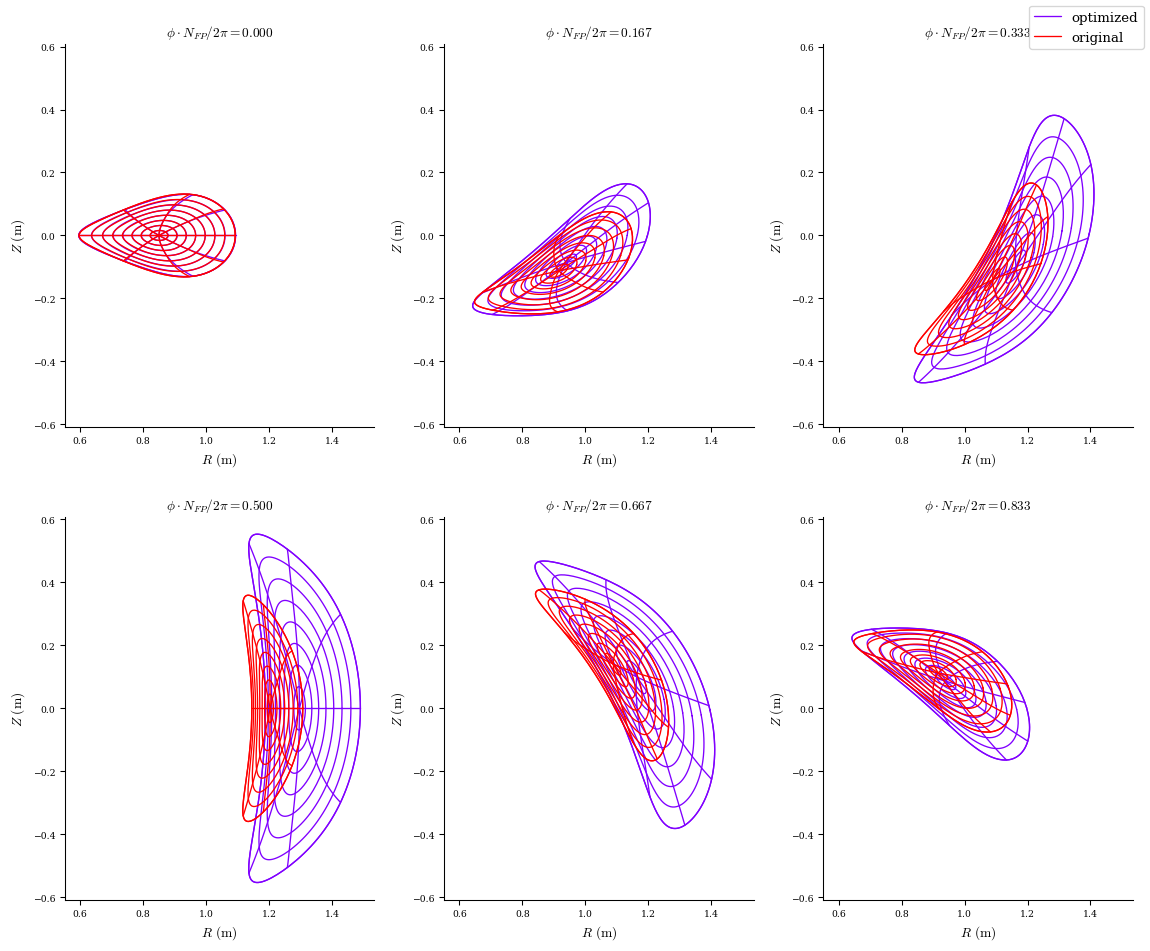

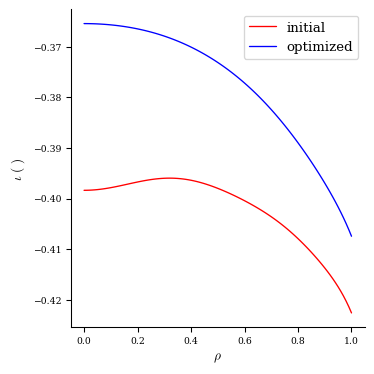

In [38]:
plot_comparison([eq_opt3, eq0], labels=["optimized", "original"])
fig, ax = plot_1d(eq0, "iota", label="initial", color="red")
plot_1d(eq_opt3, "iota", ax=ax, label="optimized", color="blue");

##########################################################
Calculating Phi_SV for lambda_regularization = 0.00000e+00
##########################################################
chi^2 B = 7.02715e-10
min Bnormal = 8.07897e-19 (T)
Max Bnormal = 2.67485e-07 (T)
Avg Bnormal = 4.21844e-08 (T)
min Bnormal = 1.31882e-18 (unitless)
Max Bnormal = 4.36644e-07 (unitless)
Avg Bnormal = 6.88622e-08 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-30
##########################################################
chi^2 B = 7.02715e-10
min Bnormal = 7.92922e-19 (T)
Max Bnormal = 2.67485e-07 (T)
Avg Bnormal = 4.21844e-08 (T)
min Bnormal = 1.29437e-18 (unitless)
Max Bnormal = 4.36644e-07 (unitless)
Avg Bnormal = 6.88622e-08 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 4.28133e-29
##########################################################
chi^2 B = 7.02715e-10
m

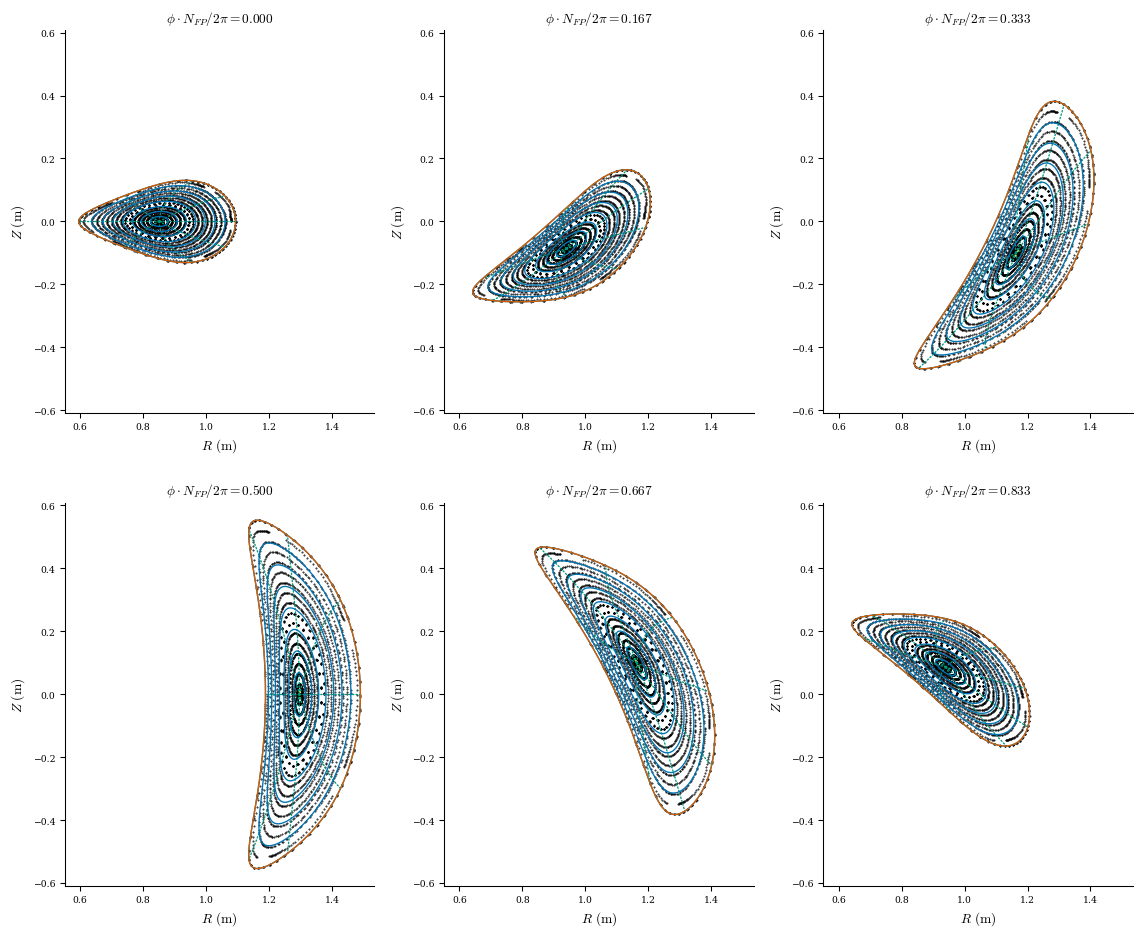

In [39]:
fig, ax = optimize_field_and_plot_result(eq_opt3, nrho=18, ntransit=200, size=0.2)

# Example from NIES 2024 Paper

In [15]:
eq0 = desc.io.load(
    "./ISLAND_STUFF/NIES2024/input.QA_Nfp3_AR_4.5_opt5_423_desc_DESC_output_LMN_10.h5"
)[-1]
eq_opt3 = eq0.copy()
# eq_opt3.change_resolution(L=8, M=4, N=4)
# eq_opt3.change_resolution(L=16, M=16, N=4, L_grid=24, M_grid=24, N_grid=8)
eq_opt3.xsection = eq_opt3.get_surface_at(zeta=0.0)
eq_opt3.surface = eq_opt3.get_surface_at(rho=1.0)
eq_opt3.axis = eq_opt3.get_axis()

w_force = 1000
w_section = 10
w_surface = 1
w_iota = 10
obj2 = ObjectiveFunction(
    [
        ForceBalance(eq_opt3, weight=w_force),
        FixSectionR(eq_opt3, remove_optimizables=False, weight=w_section),
        FixSectionZ(eq_opt3, remove_optimizables=False, weight=w_section),
        FixBoundaryR(eq_opt3, remove_optimizables=False, weight=w_surface),
        FixBoundaryZ(eq_opt3, remove_optimizables=False, weight=w_surface),
        # RotationalTransform(eq_opt3, target=-0.42, grid=iota_grid, weight=w_iota),
    ]
)

cons = (
    FixPressure(eq_opt3),
    FixPsi(eq_opt3),
    FixCurrent(eq_opt3),
    FixLambdaGauge(eq_opt3),
    FixSheetCurrent(eq_opt3),
)
cons = maybe_add_self_consistency(eq_opt3, cons)

/CODES/DESC/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_rho' was not loaded from the file.
This is likely because the file containing 'FourierRZToroidalSurface' was created before '_rho' became an attribute of objects of class '<class 'desc.geometry.surface.FourierRZToroidalSurface'>'.
The user may verify that a default value has been set.
This warning will persist until the file is saved with the new object.

Note to developers: Add 'def _set_up(self)' as a method to class '<class 'desc.geometry.surface.FourierRZToroidalSurface'>'
(or the superclass where this new attribute is assigned) that assigns a value to '_rho'.
This method is called automatically when a file is loaded.
Recall that the testing suite will fail on warnings.
  warnings.warn(
/CODES/DESC/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_shift' was not loaded from the file.
This is likely because the file containing 'FourierRZCurve' was created before '_shift' became an attribute of 

In [16]:
eq_opt3.solve(objective=obj2, constraints=cons, verbose=3, ftol=1e-2, maxiter=100)
eq_opt3.xsection = eq_opt3.get_surface_at(zeta=0.0)
eq_opt3.surface = eq_opt3.get_surface_at(rho=1.0)
eq_opt3.axis = eq_opt3.get_axis()

Building objective: force
Precomputing transforms


Timer: Precomputing transforms = 74.0 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Timer: Objective build = 171 ms
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Building objective: lambda gauge
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 120 ms
Timer: LinearConstraintProjection build = 505 ms
Number of parameters: 2076
Number of objectives: 10429
Timer: Initializing the optimization = 871 ms

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction

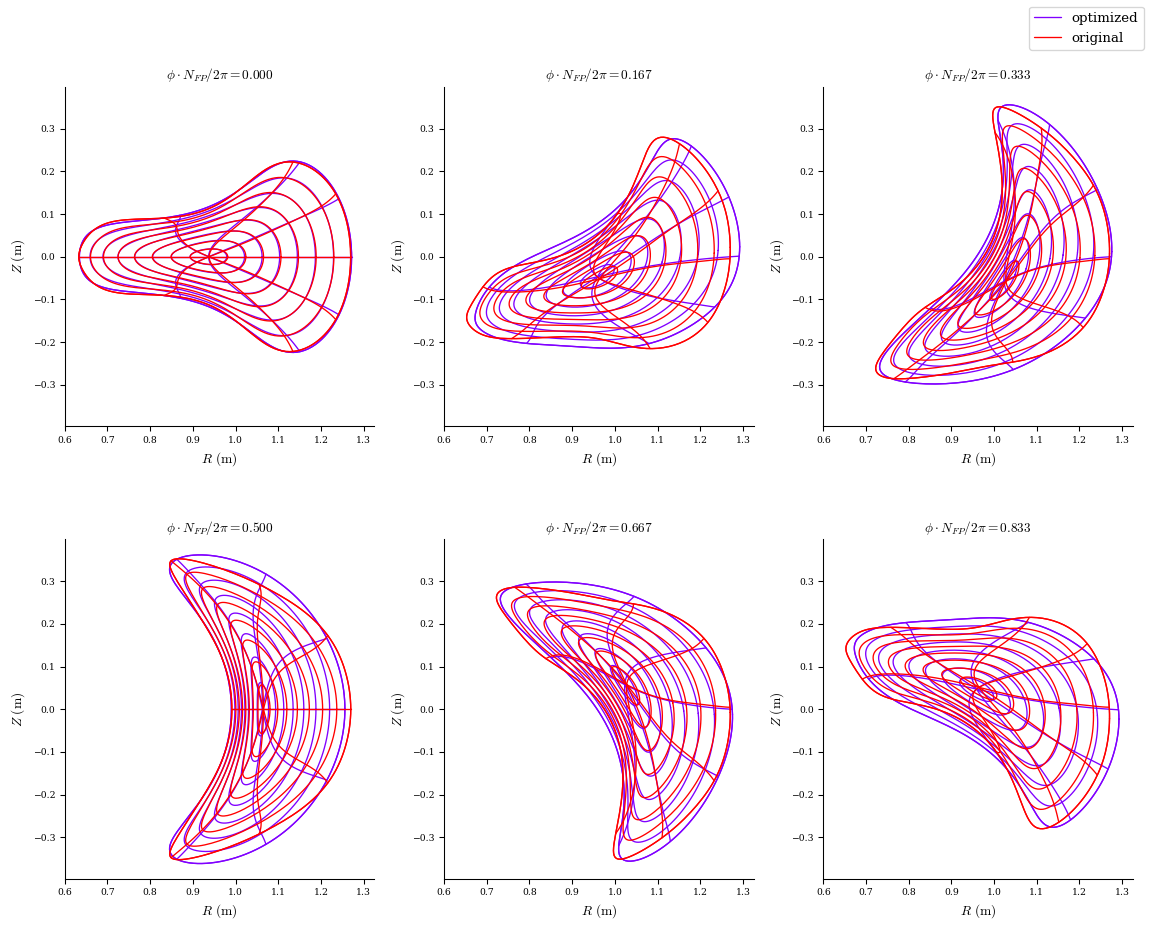

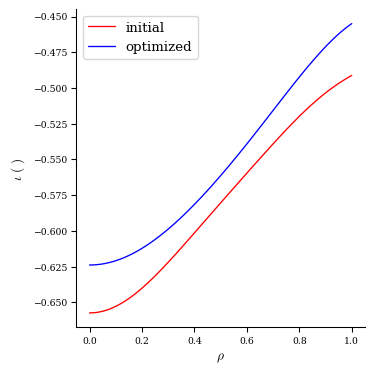

In [17]:
plot_comparison([eq_opt3, eq0], labels=["optimized", "original"])
fig, ax = plot_1d(eq0, "iota", label="initial", color="red")
plot_1d(eq_opt3, "iota", ax=ax, label="optimized", color="blue");

In [ ]:
fig, ax = optimize_field_and_plot_result(eq_opt3, nrho=18, ntransit=100, size=0.2, offset=0.3)

##########################################################
Calculating Phi_SV for lambda_regularization = 0.00000e+00
##########################################################
chi^2 B = 7.51671e-04
min Bnormal = 1.10775e-15 (T)
Max Bnormal = 2.33605e-04 (T)
Avg Bnormal = 4.25272e-05 (T)
min Bnormal = 1.83532e-16 (unitless)
Max Bnormal = 3.87038e-05 (unitless)
Avg Bnormal = 7.04591e-06 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-30
##########################################################
chi^2 B = 7.51677e-04
min Bnormal = 5.23212e-16 (T)
Max Bnormal = 2.33522e-04 (T)
Avg Bnormal = 4.25292e-05 (T)
min Bnormal = 8.66859e-17 (unitless)
Max Bnormal = 3.86899e-05 (unitless)
Avg Bnormal = 7.04625e-06 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 4.28133e-29
##########################################################
chi^2 B = 7.54354e-04
m